In [77]:
import pandas as pd
import numpy as np
import sqlite3
import datetime
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns


from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.filters.hp_filter import hpfilter


import warnings
warnings.filterwarnings('ignore')

# Adjust pandas display settings
pd.options.display.float_format = '{:.6f}'.format

In [2]:
# Connect to the SQLite3 database
conn = sqlite3.connect('binance_data.db')
cursor = conn.cursor()

# Execute the JOIN query to get the necessary data
query = """
SELECT 
    currencies.id AS currency_id, 
    currencies.pair, 
    pairs_price.*
FROM 
    pairs_price
JOIN 
    currencies 
ON 
    pairs_price.pair_id = currencies.id;
"""

# Load the query results into a Pandas DataFrame
df = pd.read_sql_query(query, conn)

# Close the database connection
conn.close()

# Convert the 'open_time' column from Unix timestamp to human-readable date format
df['open_time'] = pd.to_datetime(df['open_time'], unit='ms')

# Set the MultiIndex with currencies.id, currencies.pair, and open_time
df.set_index(['currency_id', 'pair'], inplace = True)

df.sort_index(level='currency_id', inplace = True)

df


id  pair_id  open_time        open        high  \
currency_id pair                                                          
1           BTCUSDT   68686        1 2017-08-17 4261.480000 4485.390000   
            BTCUSDT   68687        1 2017-08-18 4285.080000 4371.520000   
            BTCUSDT   68688        1 2017-08-19 4108.370000 4184.690000   
            BTCUSDT   68689        1 2017-08-20 4120.980000 4211.080000   
            BTCUSDT   68690        1 2017-08-21 4069.130000 4119.620000   
...                     ...      ...        ...         ...         ...   
382         ZROUSDT  417639      382 2024-07-07    4.201000    4.377000   
            ZROUSDT  417640      382 2024-07-08    4.000000    4.120000   
            ZROUSDT  417641      382 2024-07-09    3.867000    4.072000   
            ZROUSDT  417642      382 2024-07-10    3.867000    4.519000   
            ZROUSDT  417643      382 2024-07-11    4.019000    4.100000   

                            low       close          volume  \
currency_id pair                                              
1           BTCUSDT 4200.740000 4285.080000      795.150377   
            BTCUSDT 3938.770000 4108.370000     1199.888264   
            BTCUSDT 3850.000000 4139.980000      381.309763   
            BTCUSDT 4032.620000 4086.290000      467.083022   
            BTCUSDT 3911.790000 4016.000000      691.743060   
...                         ...         ...             ...   
382         ZROUSDT    3.713000    4.000000 24447217.480000   
            ZROUSDT    3.682000    3.868000 21960978.270000   
            ZROUSDT    3.741000    3.865000 13180168.440000   
            ZROUSDT    3.666000    4.019000 19475418.850000   
            ZROUSDT    3.820000    3.927000  6025541.340000   

                     quote_asset_volume  number_of_trades  \
currency_id pair                                            
1           BTCUSDT      3454770.050732       3427.000000   
            BTCUSDT      5086958.306172       5233.000000   
            BTCUSDT      1549483.735422       2153.000000   
            BTCUSDT      1930364.390326       2321.000000   
            BTCUSDT      2797231.714027       3972.000000   
...                                 ...               ...   
382         ZROUSDT     98103447.662620     320230.000000   
            ZROUSDT     85125041.988560     316652.000000   
            ZROUSDT     51074079.159230     186738.000000   
            ZROUSDT     81452065.636800     264303.000000   
            ZROUSDT     23666532.527780      87180.000000   

                     taker_buy_base_asset_volume  taker_buy_quote_asset_volume  
currency_id pair                                                                
1           BTCUSDT                   616.248541                2678216.400604  
            BTCUSDT                   972.868710                4129123.316518  
            BTCUSDT                   274.336042                1118001.870087  
            BTCUSDT                   376.795947                1557401.333737  
            BTCUSDT                   557.356107                2255662.553158  
...                                          ...                           ...  
382         ZROUSDT              12351461.600000               49588446.141160  
            ZROUSDT              10867181.390000               42108711.519280  
            ZROUSDT               6905082.690000               26766180.283720  
            ZROUSDT               9920741.640000               41533285.609520  
            ZROUSDT               3314811.440000               13017832.724260  

[419604 rows x 12 columns]

In [3]:
# Check for any missing days in the date range
def identify_missing_days(data):
    data["open_time"] = pd.to_datetime(data["open_time"])  # Ensure datetime format
    date_range = pd.date_range(start=data["open_time"].min(), end=data["open_time"].max())
    missing_days = date_range.difference(data["open_time"])
    return missing_days

# Fill missing values with the previous row's value
def fill_missing_values(data, missing_days):
    filled_data = data.set_index("open_time").reindex(
        pd.date_range(start=data["open_time"].min(), end=data["open_time"].max())
    ).fillna(method="ffill").reset_index()
    filled_data.rename(columns={"index": "open_time"}, inplace=True)
    return filled_data

# Apply the function to each timeseries in the filtered DataFrame and print information
def process_and_log(name, group):
    missing_days = identify_missing_days(group)
    return len(group), len(missing_days)

# Assuming df is your DataFrame and it has "currency_id", "pair", and "open_time" columns
def apply_group_processing(df):
    results = []
    for name, group in df.groupby(["currency_id", "pair"]):
        length, missing_count = process_and_log(name, group)
        if length > 0:
            percent_missing_dates = (missing_count / length) * 100
        else:
            percent_missing_dates = float("nan")  # or 0, or any other value you prefer
        
        results.append((name[0], name[1], length, missing_count, percent_missing_dates))
    
    result_df = pd.DataFrame(results, columns=["currency_id", "pair", "length", "missing_count", "missing_%"])
    result_df.set_index(["currency_id", "pair"], inplace=True)
    return result_df

# Call the function to apply the group processing
data_cleansing = apply_group_processing(df)

# Sort the result by missing_count
data_cleansing_sorted = data_cleansing.sort_values(by="missing_count", ascending=False)

# Display the result with missing values
print(data_cleansing_sorted[data_cleansing_sorted["missing_count"] > 0])

# Apply fill_missing_values for tickers where % of missing values is less than 1%
def apply_fill_missing(df, cleansing_df):
    filled_groups = []
    for name, group in df.groupby(["currency_id", "pair"]):
        if (name in cleansing_df.index) and (cleansing_df.loc[name, "missing_%"] < 1):
            missing_days = identify_missing_days(group)
            group = fill_missing_values(group, missing_days)
            group["currency_id"] = name[0]
            group["pair"] = name[1]
        filled_groups.append(group)
    
    filled_df = pd.concat(filled_groups).reset_index(drop=True)
    filled_df.set_index(["currency_id", "pair", "open_time"], inplace=True)
    return filled_df

# Filter out symbols with more than 1% missing values
filtered_data_cleansing_sorted = data_cleansing_sorted[data_cleansing_sorted["missing_%"] < 1]

# Apply the function to fill missing values conditionally
filled_data = apply_fill_missing(df, filtered_data_cleansing_sorted)

# Display the filled data
filled_data


                       length  missing_count  missing_%
currency_id pair                                       
67          FTTUSDT      1356            310  22.861357
10          TUSDUSDT     2069            165   7.974867
217         USDPUSDT      871            165  18.943743
19          USDCUSDT     1871            165   8.818813
50          CVCUSDT      1628            153   9.398034
46          KEYUSDT      1754             27   1.539339
108         LUNAUSDT     1404             17   1.210826
216         VIDTUSDT     1029              8   0.777454
139         STRAXUSDT    1325              7   0.528302
235         BNXUSDT       976              5   0.512295
123         SUNUSDT      1387              3   0.216294
205         QUICKUSDT    1061              3   0.282752
346         AEURUSDT      219              2   0.913242


id    pair_id        open  \
currency_id pair    open_time                                         
1.000000    BTCUSDT 2017-08-17  68686.000000   1.000000 4261.480000   
                    2017-08-18  68687.000000   1.000000 4285.080000   
                    2017-08-19  68688.000000   1.000000 4108.370000   
                    2017-08-20  68689.000000   1.000000 4120.980000   
                    2017-08-21  68690.000000   1.000000 4069.130000   
...                                      ...        ...         ...   
382.000000  ZROUSDT 2024-07-07 417639.000000 382.000000    4.201000   
                    2024-07-08 417640.000000 382.000000    4.000000   
                    2024-07-09 417641.000000 382.000000    3.867000   
                    2024-07-10 417642.000000 382.000000    3.867000   
                    2024-07-11 417643.000000 382.000000    4.019000   

                                      high         low       close  \
currency_id pair    open_time                                        
1.000000    BTCUSDT 2017-08-17 4485.390000 4200.740000 4285.080000   
                    2017-08-18 4371.520000 3938.770000 4108.370000   
                    2017-08-19 4184.690000 3850.000000 4139.980000   
                    2017-08-20 4211.080000 4032.620000 4086.290000   
                    2017-08-21 4119.620000 3911.790000 4016.000000   
...                                    ...         ...         ...   
382.000000  ZROUSDT 2024-07-07    4.377000    3.713000    4.000000   
                    2024-07-08    4.120000    3.682000    3.868000   
                    2024-07-09    4.072000    3.741000    3.865000   
                    2024-07-10    4.519000    3.666000    4.019000   
                    2024-07-11    4.100000    3.820000    3.927000   

                                        volume  quote_asset_volume  \
currency_id pair    open_time                                        
1.000000    BTCUSDT 2017-08-17      795.150377      3454770.050732   
                    2017-08-18     1199.888264      5086958.306172   
                    2017-08-19      381.309763      1549483.735422   
                    2017-08-20      467.083022      1930364.390326   
                    2017-08-21      691.743060      2797231.714027   
...                                        ...                 ...   
382.000000  ZROUSDT 2024-07-07 24447217.480000     98103447.662620   
                    2024-07-08 21960978.270000     85125041.988560   
                    2024-07-09 13180168.440000     51074079.159230   
                    2024-07-10 19475418.850000     81452065.636800   
                    2024-07-11  6025541.340000     23666532.527780   

                                number_of_trades  taker_buy_base_asset_volume  \
currency_id pair    open_time                                                   
1.000000    BTCUSDT 2017-08-17       3427.000000                   616.248541   
                    2017-08-18       5233.000000                   972.868710   
                    2017-08-19       2153.000000                   274.336042   
                    2017-08-20       2321.000000                   376.795947   
                    2017-08-21       3972.000000                   557.356107   
...                                          ...                          ...   
382.000000  ZROUSDT 2024-07-07     320230.000000              12351461.600000   
                    2024-07-08     316652.000000              10867181.390000   
                    2024-07-09     186738.000000               6905082.690000   
                    2024-07-10     264303.000000               9920741.640000   
                    2024-07-11      87180.000000               3314811.440000   

                                taker_buy_quote_asset_volume  
currency_id pair    open_time                                 
1.000000    BTCUSDT 2017-08-17                2678216.400604  
                    2017-08-18                4129123

In [4]:
filled_data.describe()

,id,pair_id,open,high,low,close,volume,quote_asset_volume,number_of_trades,taker_buy_base_asset_volume,taker_buy_quote_asset_volume
count,419632.000000,419632.000000,419632.000000,419632.000000,419632.000000,419632.000000,419632.000000,419632.000000,419632.000000,419632.000000,419632.000000
mean,209807.030808,134.870394,283.366696,292.198843,274.057022,283.562655,79184732141.966171,38433161.677937,75147.835406,39374854258.991409,19086224.673315
std,121131.583597,94.081727,3061.505265,3151.928021,2965.622852,3063.729275,2041321007357.600342,251450782.201453,295994.423135,1033334149584.215454,125106801.584424
min,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.553260,482.811452,11.000000,0.316520,318.116636
25%,104901.750000,53.000000,0.086100,0.090215,0.082430,0.086100,1134053.417175,1098741.627949,7556.000000,544599.800000,525605.446500
50%,209809.500000,122.000000,0.538000,0.567600,0.512100,0.537900,6981622.300000,3506906.525044,20024.000000,3369811.125000,1701734.148631
75%,314714.250000,207.000000,3.510250,3.709000,3.335200,3.508000,44985288.637500,13581637.327357,55046.250000,21924163.000000,6708850.209808
max,419604.000000,382.000000,82875.440000,95000.000000,71333.310000,82885.120000,254270289671127.000000,17598561857.084930,15920580.000000,133050653421907.000000,9013969074.852932


In [5]:
filled_data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 419632 entries, (1.0, 'BTCUSDT', Timestamp('2017-08-17 00:00:00')) to (382.0, 'ZROUSDT', Timestamp('2024-07-11 00:00:00'))
Data columns (total 11 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   id                            419632 non-null  float64
 1   pair_id                       419632 non-null  float64
 2   open                          419632 non-null  float64
 3   high                          419632 non-null  float64
 4   low                           419632 non-null  float64
 5   close                         419632 non-null  float64
 6   volume                        419632 non-null  float64
 7   quote_asset_volume            419632 non-null  float64
 8   number_of_trades              419632 non-null  float64
 9   taker_buy_base_asset_volume   419632 non-null  float64
 10  taker_buy_quote_asset_volume  419632 non-null  float64
dtypes: float6

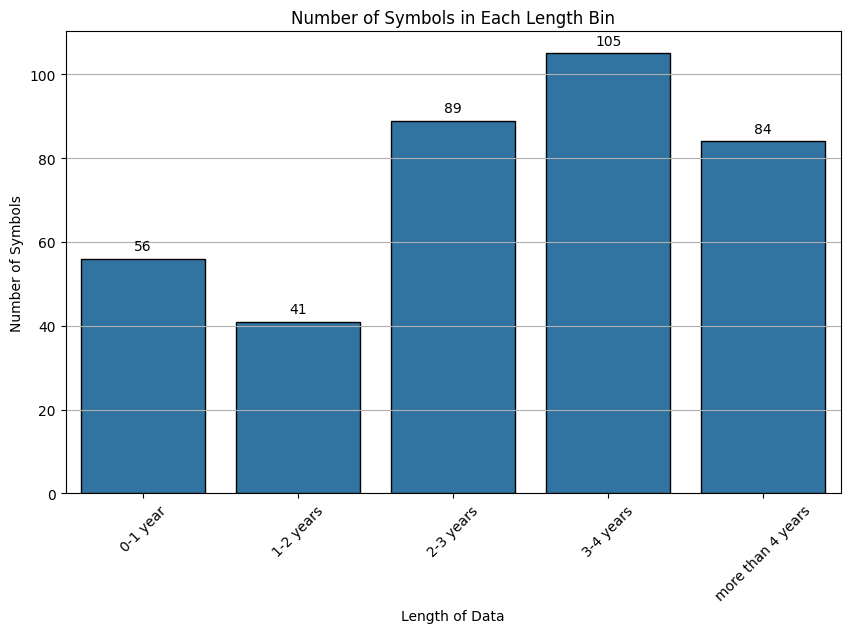

In [6]:
# Function to get the length of each group
def get_group_length(data):
    return len(data)

# Group by 'currency_id' and 'pair', then apply the function to get the length of each group
group_lengths = filled_data.groupby(level=['currency_id', 'pair']).apply(get_group_length)

# Convert the result to a DataFrame for better readability
group_lengths_df = group_lengths.reset_index(name='length')

# Define bins for the specified periods in days
bins = [0, 365, 2*365, 3*365, 4*365, float('inf')]
labels = ['0-1 year', '1-2 years', '2-3 years', '3-4 years', 'more than 4 years']

# Bin the lengths into the specified intervals
group_lengths_df['length_bin'] = pd.cut(group_lengths_df['length'], bins=bins, labels=labels, right=False)

# Count the number of tickers in each bin
bin_counts = group_lengths_df['length_bin'].value_counts().sort_index()

# Convert bin_counts to DataFrame for seaborn plotting
bin_counts_df = bin_counts.reset_index()
bin_counts_df.columns = ['Length Bin', 'Number of Symbols']

# Plot the counts for each bin using seaborn
plt.figure(figsize=(10, 6))
barplot = sns.barplot(x='Length Bin', y='Number of Symbols', data=bin_counts_df, edgecolor='black')

# Annotate the bars with the number of values
for p in barplot.patches:
    barplot.annotate(format(p.get_height(), '.0f'), 
                     (p.get_x() + p.get_width() / 2., p.get_height()), 
                     ha = 'center', va = 'center', 
                     xytext = (0, 9), 
                     textcoords = 'offset points')

plt.xlabel('Length of Data')
plt.ylabel('Number of Symbols')
plt.title('Number of Symbols in Each Length Bin')
plt.xticks(rotation=45)
plt.grid(axis='y')  # Only horizontal grid lines
plt.show()


In [7]:
# Filter pairs with length greater than 365 days
long_pairs = group_lengths[group_lengths > 365].index

# Create a boolean mask to filter the original dataframe
mask = filled_data.index.get_level_values('currency_id').isin(long_pairs.get_level_values('currency_id')) & \
       filled_data.index.get_level_values('pair').isin(long_pairs.get_level_values('pair'))

filtered_df = filled_data[mask]

In [103]:
def calculate_return(data):
    data["daily_change_%"] = data["close"].pct_change()
    data["returns"] = ((1 + data["daily_change_%"].apply(np.prod, raw = True) - 1).shift(-1)


In [13]:
# Load the dataset
eda_data = filtered_df.reset_index()

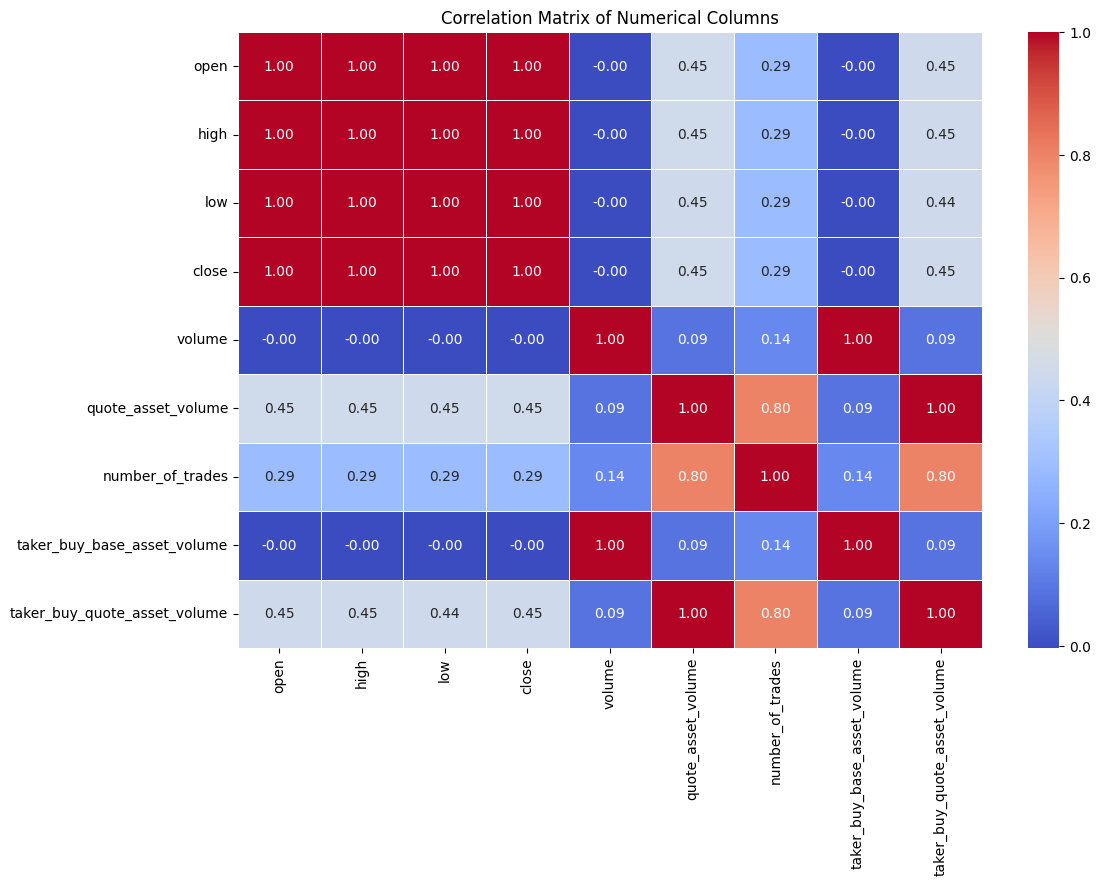

In [14]:
numerical_columns = eda_data.columns[5:]

# Correlation analysis between numerical columns
correlation_matrix = eda_data[numerical_columns].corr()

# Plotting the correlation heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix of Numerical Columns')
plt.show()

In [15]:
from scipy.stats import shapiro, anderson

# Reset the index to work with open_time as a column
data = eda_data

# Function to identify if the distribution of a column is normal using Shapiro-Wilk and Anderson-Darling tests
def identify_distribution(data, column):
    results = {}
    # Perform Shapiro-Wilk test
    stat, p = shapiro(data[column])
    results["shapiro"] = p > 0.05  # Normal if p > 0.05
    
    # Perform Anderson-Darling test
    result = anderson(data[column])
    results["anderson"] = result.statistic < result.critical_values[2]  # Normal if statistic < critical value at 5% level
    
    return results

# Get the unique combinations of currency_id and pair
unique_pairs = data[["currency_id", "pair"]].drop_duplicates()
columns_to_test = numerical_columns
# Initialize the results DataFrame with the correct multi-index
index = pd.MultiIndex.from_frame(unique_pairs)
results_df = pd.DataFrame(index=index, columns=pd.MultiIndex.from_product([columns_to_test, ['shapiro', 'anderson']], names=['column', 'test']))

# Function to apply normality tests and log results
def process_and_log(name, group):
    for column in columns_to_test:
        if column in group.columns:
            test_results = identify_distribution(group, column)
            results_df.loc[name, (column, 'shapiro')] = test_results['shapiro']
            results_df.loc[name, (column, 'anderson')] = test_results['anderson']
        else:
            results_df.loc[name, (column, 'shapiro')] = None
            results_df.loc[name, (column, 'anderson')] = None

# Apply the function to each group
for name, group in data.groupby(['currency_id', 'pair']):
    process_and_log(name, group)

# Fill NaN values with False for pairs that do not have data in columns_to_test
results_df = results_df.fillna(False)

# Print the resulting DataFrame
results_df.sum()



column                        test    
open                          shapiro     0
                              anderson    0
high                          shapiro     0
                              anderson    0
low                           shapiro     0
                              anderson    0
close                         shapiro     0
                              anderson    0
volume                        shapiro     0
                              anderson    0
quote_asset_volume            shapiro     0
                              anderson    0
number_of_trades              shapiro     0
                              anderson    0
taker_buy_base_asset_volume   shapiro     0
                              anderson    0
taker_buy_quote_asset_volume  shapiro     0
                              anderson    0
dtype: int64

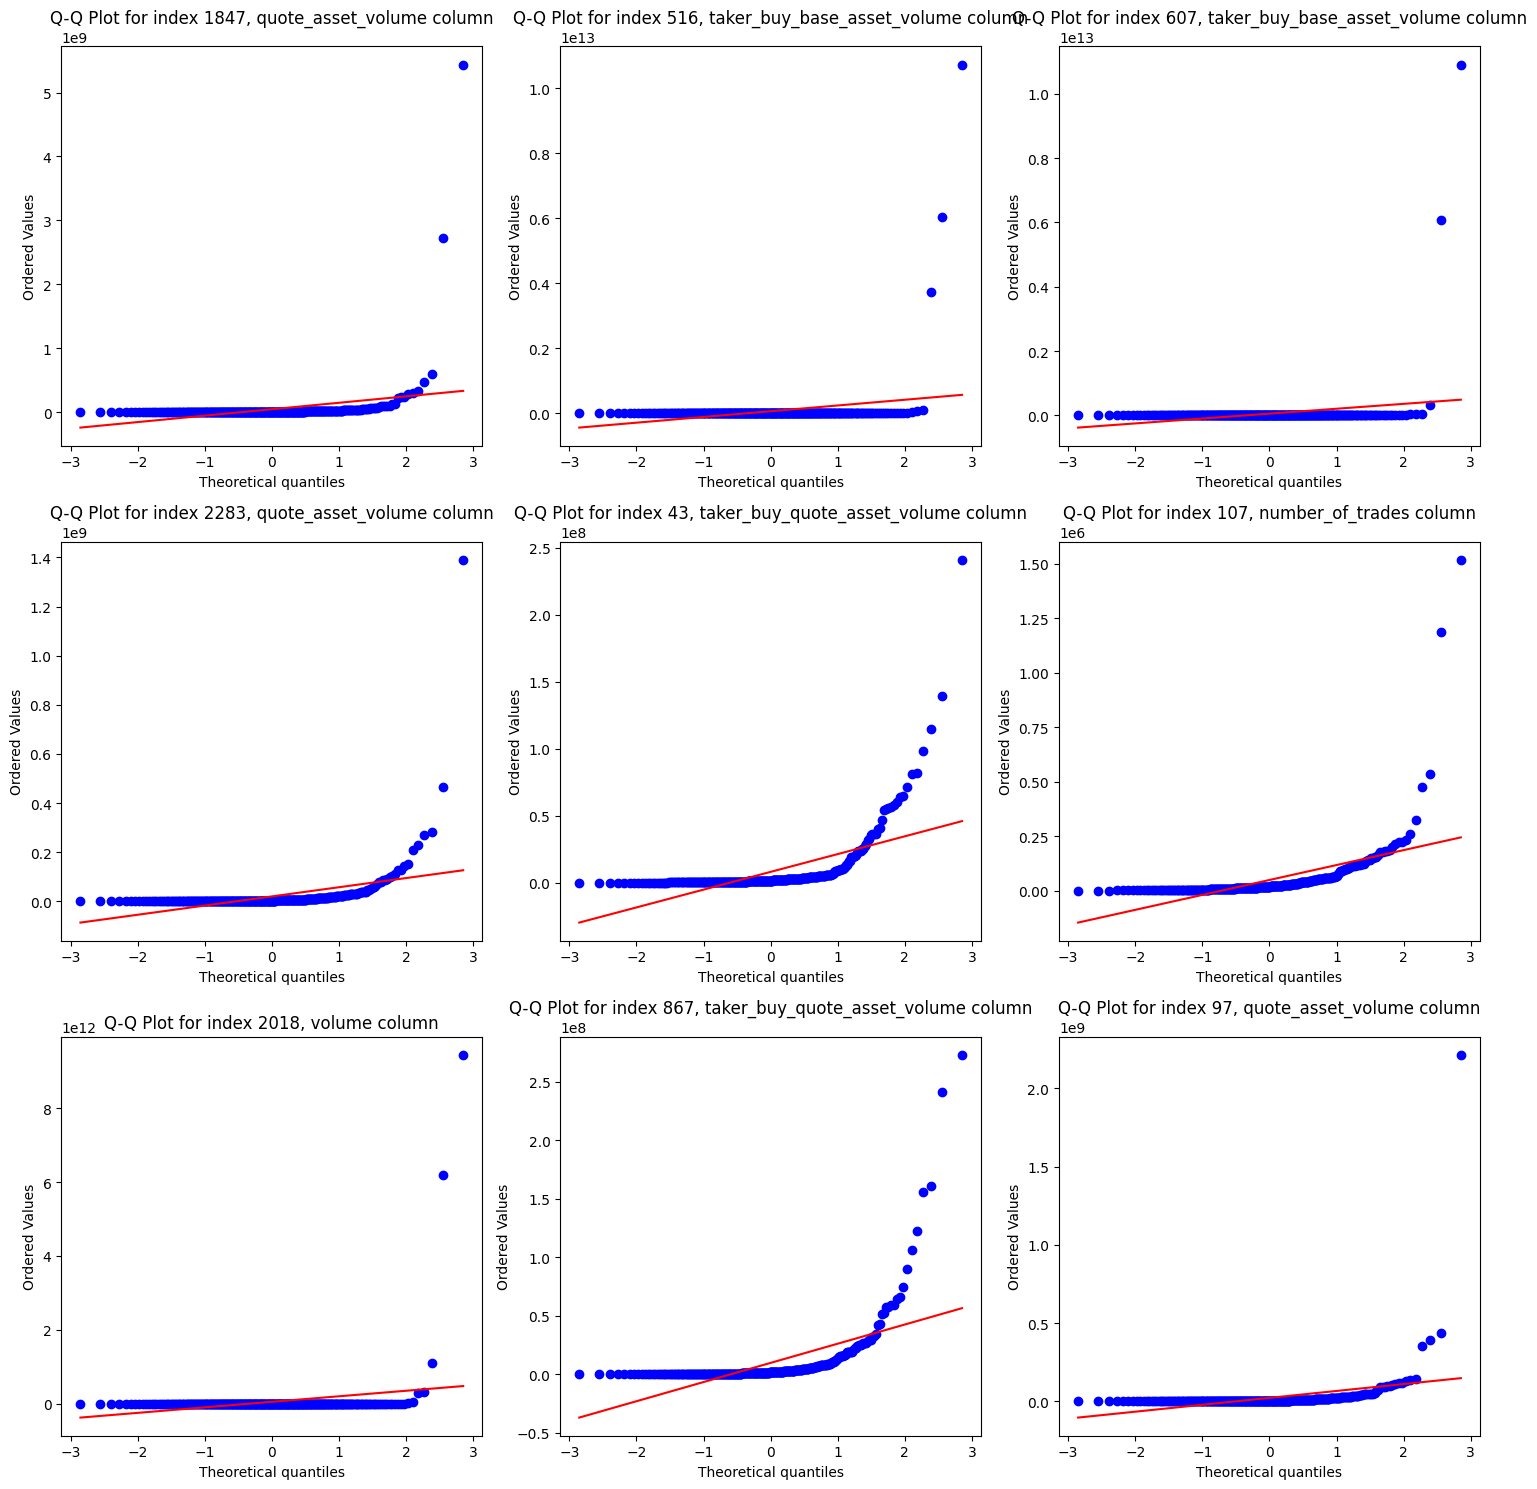

In [16]:
import scipy.stats as stats
import random

# Reset the index to work with open_time as a column
data = eda_data.reset_index()

# Columns to test
columns_to_test = ["volume", "quote_asset_volume", "number_of_trades", "taker_buy_base_asset_volume", "taker_buy_quote_asset_volume"]

# Function to plot random distribution charts
def random_distribution_plots(data, n_plots=6, rows=2):
    cols = n_plots // rows
    fig, axs = plt.subplots(rows, cols, figsize=(cols * 5, rows * 5))
    axs = axs.flatten()
    
    for i in range(n_plots):
        # Get a random group (currency_id, pair) and a random column
        data_group_random = data.groupby(['currency_id', 'pair']).sample(n=1)
        data_index_random = data_group_random.index[0]
        data_column_random = random.choice(columns_to_test)
        
        # Extract the data series for the random column within the group
        series_to_plot = data_group_random[data_column_random]
        
        # Plot the Q-Q plot
        stats.probplot(series_to_plot, dist="norm", plot=axs[i])
        axs[i].set_title(f"Q-Q Plot for index {data_index_random}, {data_column_random} column")
    
    plt.tight_layout()
    plt.show()

# Plot 6 random distribution charts in a 2x3 grid
random_distribution_plots(data, n_plots=9, rows=3)


In [17]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from scipy.stats import boxcox

# Load the dataset
data = eda_data

# Initialize a list to store the log information
log_info = []

# Function to identify outliers using DBSCAN and replace them with the average of the previous 15 days
def identify_replace_outliers_dbscan(group, column, group_name):
    # Scale the data
    scaler = StandardScaler()
    group_scaled = scaler.fit_transform(group[[column]])
    
    # Apply DBSCAN to detect outliers
    dbscan = DBSCAN(eps=1, min_samples=5)
    group['is_outlier_dbscan'] = dbscan.fit_predict(group_scaled) == -1
    
    # Replace outliers with the average of the previous 15 days
    outliers_count = group['is_outlier_dbscan'].sum()
    log_info.append({
        'group': group_name,
        'column': column,
        'outliers_count': outliers_count,
        'method': 'dbscan'
    })
    
    group.loc[group['is_outlier_dbscan'], column] = group[column].rolling(window=30, min_periods=1).mean()
    
    # Drop the temporary columns
    group = group.drop(columns=['is_outlier_dbscan'])
    
    return group

# Function to apply Box-Cox transformation and then check for outliers using Z-score
def identify_replace_outliers_boxcox(group, column, group_name):
    # Apply Box-Cox transformation
    group['transformed'], _ = boxcox(group[column] + 1)  # Box-Cox requires positive data
    group['z_score'] = (group['transformed'] - group['transformed'].mean()) / group['transformed'].std()
    z_score_threshold = 3
    group[f'is_outlier_boxcox_{column}'] = np.abs(group['z_score']) > z_score_threshold
    
    # Replace outliers with the average of the previous 15 days
    outliers_count = group[f'is_outlier_boxcox_{column}'].sum()
    log_info.append({
        'group': group_name,
        'column': column,
        'outliers_count': outliers_count,
        'method': 'boxcox'
    })
    
    group.loc[group[f'is_outlier_boxcox_{column}'], column] = group[column].rolling(window=30, min_periods=1).mean()
    
    # Drop the temporary columns
    group = group.drop(columns=['transformed', 'z_score', f'is_outlier_boxcox_{column}'])
    
    return group

# Function to perform a second check for outliers using DBSCAN and Box-Cox after replacement
def second_check_outliers(group, column, method):
    if method == 'dbscan':
        # Scale the data
        scaler = StandardScaler()
        group_scaled = scaler.fit_transform(group[[column]])
        
        # Apply DBSCAN
        dbscan = DBSCAN(eps=1, min_samples=5)
        group['is_outlier_dbscan_second'] = dbscan.fit_predict(group_scaled) == -1
        second_outliers_count = group['is_outlier_dbscan_second'].sum()
        group = group.drop(columns=['is_outlier_dbscan_second'])
    elif method == 'boxcox':
        group['transformed'], _ = boxcox(group[column] + 1)  # Box-Cox requires positive data
        group['z_score'] = (group['transformed'] - group['transformed'].mean()) / group['transformed'].std()
        z_score_threshold = 3
        group[f'is_outlier_boxcox_{column}_second'] = np.abs(group['z_score']) > z_score_threshold
        second_outliers_count = group[f'is_outlier_boxcox_{column}_second'].sum()
        group = group.drop(columns=['transformed', 'z_score', f'is_outlier_boxcox_{column}_second'])
    
    return second_outliers_count

# Function to process tickers separately
def process_and_log(name, group):
    columns_to_test = ["volume", "quote_asset_volume", "number_of_trades", "taker_buy_base_asset_volume", "taker_buy_quote_asset_volume"]
    
    for column in columns_to_test:
        if column in group.columns:
            # First, apply DBSCAN method
            group = identify_replace_outliers_dbscan(group, column, name)
            second_outliers_count_dbscan = second_check_outliers(group, column, 'dbscan')
            
            # Then, apply Box-Cox method
            group = identify_replace_outliers_boxcox(group, column, name)
            second_outliers_count_boxcox = second_check_outliers(group, column, 'boxcox')
            
            # Append second check info to log
            log_info[-2]['second_check_outliers'] = second_outliers_count_dbscan
            log_info[-1]['second_check_outliers'] = second_outliers_count_boxcox
    
    return group

# Apply the function to each group
processed_groups = []
for name, group in data.groupby(['currency_id', 'pair']):
    processed_group = process_and_log(name, group)
    processed_groups.append(processed_group)

# Concatenate all processed groups back into a single DataFrame
processed_data = pd.concat(processed_groups)

# Create a DataFrame from the log information
log_df = pd.DataFrame(log_info)

# Display the log DataFrame and the updated dataset
log_df.head(10)

,group,column,outliers_count,method,second_check_outliers
0,"(1.0, BTCUSDT)",volume,0,dbscan,0
1,"(1.0, BTCUSDT)",volume,19,boxcox,1
2,"(1.0, BTCUSDT)",quote_asset_volume,0,dbscan,0
3,"(1.0, BTCUSDT)",quote_asset_volume,0,boxcox,0
4,"(1.0, BTCUSDT)",number_of_trades,0,dbscan,0
5,"(1.0, BTCUSDT)",number_of_trades,1,boxcox,0
6,"(1.0, BTCUSDT)",taker_buy_base_asset_volume,0,dbscan,0
7,"(1.0, BTCUSDT)",taker_buy_base_asset_volume,23,boxcox,1
8,"(1.0, BTCUSDT)",taker_buy_quote_asset_volume,0,dbscan,0
9,"(1.0, BTCUSDT)",taker_buy_quote_asset_volume,1,boxcox,0


In [19]:
processed_data.set_index(['currency_id', 'pair'], inplace = True)

In [20]:
# Create Simple Moving Averages for Close price
sma_list = [x for x in range(10, 370, 10)]

# Function to process each timeseries
def process_timeseries(data):
    # Create SMAs
    for sma in sma_list:
        data[f"sma_{sma}"] = np.nan
        data[f"sma_{sma}"] = data['close'].rolling(window=sma).mean()

    # Create columns for percent difference between "close" and SMAs
    for movings in data.columns:
        if movings.startswith("sma"):
            column_name = f'price_diff_from_{movings}'
            moving_num = int(movings.split("_")[1])
            data[column_name] = (data["close"] - data[movings]) / data[movings] * moving_num

    # Create volume indicators
    # Average trade size relative
    data["avg_trade_size_in_quote_asset"] = (data['volume'] / data['number_of_trades']) * (data['quote_asset_volume'] / data['volume'])


    data["avg_trade_size_rel"] = (data['volume'] / data['number_of_trades']) / data['volume']

    # Trade intensity relative
    data["trade_intensity"] = data['number_of_trades'] / data['volume']
    
    # Normalize trade intensity
    rolling_window = 30  # Example rolling window size
    data['trade_intensity_mean'] = data['trade_intensity'].rolling(window=rolling_window).mean()
    data['trade_intensity_std'] = data['trade_intensity'].rolling(window=rolling_window).std()
    data['trade_intensity_rel'] = (data['trade_intensity'] - data['trade_intensity_mean']) / data['trade_intensity_std']

    # Calculate Taker Buy Ratio
    taker_buy_ratio = data['taker_buy_base_asset_volume'] / data['volume']

    # Calculate Taker Sell Ratio
    taker_sell_ratio = (data['volume'] - data['taker_buy_base_asset_volume']) / data['volume']
    
    # Calculate Taker Buy to Taker Sell Ratio
    data['taker_buy_to_sell_ratio'] = taker_buy_ratio / taker_sell_ratio

    # Drop intermediate columns
    data.drop(columns=["trade_intensity","trade_intensity_mean", "trade_intensity_std"], inplace=True)

    # Drop rows with NaNs which appeared from creating SMAs
    data = data.dropna()

    # Scale price difference columns with StandardScaler
    scaler_price_diff = StandardScaler()
    columns_to_scale_price_diff = [col for col in data.columns if col.startswith('price_diff_from_sma')]
    data[columns_to_scale_price_diff] = scaler_price_diff.fit_transform(data[columns_to_scale_price_diff])

    # Scale volume indicators with StandardScaler
    scaler_volume_indicators = StandardScaler()
    columns_to_scale_volume = ["avg_trade_size_rel", "trade_intensity_rel", "taker_buy_to_sell_ratio"]
    data[columns_to_scale_volume] = scaler_volume_indicators.fit_transform(data[columns_to_scale_volume])
    
    return data

# Apply the function to each timeseries in the filtered DataFrame and print information
def process_and_log(name, group):
    processed_group = process_timeseries(group)
    print(f"Finished processing pair: {name[1]}, number of rows processed: {len(processed_group)}")
    return processed_group

# Apply the function to each timeseries in the filtered DataFrame
result = processed_data.groupby(level=['currency_id', 'pair']).apply(lambda group: process_and_log(group.name, group))

# Reset the index using level numbers to avoid duplicated column names
result = result.reset_index(level=[0, 1])

# The result DataFrame will contain the processed data for each timeseries


Finished processing pair: BTCUSDT, number of rows processed: 2162
Finished processing pair: ETHUSDT, number of rows processed: 2162
Finished processing pair: BNBUSDT, number of rows processed: 2081
Finished processing pair: NEOUSDT, number of rows processed: 2067
Finished processing pair: LTCUSDT, number of rows processed: 2044
Finished processing pair: QTUMUSDT, number of rows processed: 1948
Finished processing pair: ADAUSDT, number of rows processed: 1919
Finished processing pair: XRPUSDT, number of rows processed: 1902
Finished processing pair: EOSUSDT, number of rows processed: 1878
Finished processing pair: IOTAUSDT, number of rows processed: 1875
Finished processing pair: XLMUSDT, number of rows processed: 1875
Finished processing pair: ONTUSDT, number of rows processed: 1867
Finished processing pair: TRXUSDT, number of rows processed: 1864
Finished processing pair: ETCUSDT, number of rows processed: 1863
Finished processing pair: ICXUSDT, number of rows processed: 1862
Finished

In [29]:
data_with_indicators = result.reset_index(drop=True)

In [31]:
# Function to define bounds of min and max values in a customized range of time (8, 15, 30 days)
def current_like_state(x: pd.DataFrame, columns: list, period_to_compare: int) -> dict:
    bounds = {'smas_values': {}, 'volume_data': {}}
    for col in columns:
        last_values = x[col].iloc[period_to_compare:][::-1]
        lower_bound = last_values.min()
        upper_bound = last_values.max()
        if col.startswith("price_diff"):
            bounds['smas_values'][col] = {'lower': lower_bound, 'upper': upper_bound}
        else:
            bounds['volume_data'][col] = {'lower': lower_bound, 'upper': upper_bound}
    return bounds

# Function to compare values extracted by "current_like_state" with historical data
def compare_values(x, lower_bound, upper_bound):
    return x if lower_bound <= x <= upper_bound else np.nan

# Assuming the DataFrame 'data_with_indicators' is already defined and processed

# Input from user for symbol and period to compare
symbol_to_compare = str(input("Symbol to compare: ")) 
period_to_compare = int(input("Period from today backwards to compare with historical data (in days): ")) * -1

# Filter the DataFrame for the specific symbol
filtered_data = data_with_indicators[data_with_indicators['pair'] == symbol_to_compare]

# Define the columns to compare
columns_to_compare = [col for col in filtered_data.columns if col.startswith("price_diff")] + [
    "avg_trade_size_in_quote_asset", 
    "avg_trade_size_rel", 
    "trade_intensity_rel", 
    "taker_buy_to_sell_ratio"
]

# Get bounds for the specified symbol
bounds_dict = current_like_state(filtered_data, columns_to_compare, period_to_compare)

# Apply "compare_values" function to the entire DataFrame using the bounds from the specified symbol
# Separate the ranges for smas_values and volume_data

# Applying for smas_values
for col, bounds in bounds_dict['smas_values'].items():
    data_with_indicators[f'range_{col}'] = data_with_indicators[col].apply(compare_values, args=(bounds['lower'], bounds['upper']))

# Applying for volume_data
for col, bounds in bounds_dict['volume_data'].items():
    data_with_indicators[f'vol_range_{col}'] = data_with_indicators[col].apply(compare_values, args=(bounds['lower'], bounds['upper']))

# Display the updated DataFrame
data_with_indicators


Symbol to compare:  ETHUSDT
Period from today backwards to compare with historical data (in days):  15


,currency_id,pair,open_time,id,pair_id,open,high,low,close,volume,...,range_price_diff_from_sma_310,range_price_diff_from_sma_320,range_price_diff_from_sma_330,range_price_diff_from_sma_340,range_price_diff_from_sma_350,range_price_diff_from_sma_360,vol_range_avg_trade_size_in_quote_asset,vol_range_avg_trade_size_rel,vol_range_trade_intensity_rel,vol_range_taker_buy_to_sell_ratio
0,1.000000,BTCUSDT,2018-08-11,69045.000000,1.000000,6148.130000,6488.000000,5971.000000,6232.350000,47133.418555,...,NaN,NaN,NaN,NaN,NaN,NaN,1232.385866,NaN,NaN,2.735839
1,1.000000,BTCUSDT,2018-08-12,69046.000000,1.000000,6222.550000,6472.300000,6130.000000,6308.330000,38567.770712,...,NaN,NaN,NaN,NaN,NaN,NaN,1277.461010,NaN,NaN,2.182938
2,1.000000,BTCUSDT,2018-08-13,69047.000000,1.000000,6308.560000,6545.000000,6145.040000,6246.350000,53895.828783,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.418412
3,1.000000,BTCUSDT,2018-08-14,69048.000000,1.000000,6248.250000,6250.330000,5880.000000,6188.080000,50186.745091,...,NaN,NaN,NaN,NaN,NaN,NaN,1203.074381,NaN,NaN,0.458010
4,1.000000,BTCUSDT,2018-08-15,69049.000000,1.000000,6188.080000,6609.000000,6172.110000,6267.160000,68806.687026,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.997188
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
283913,326.000000,PENDLEUSDT,2024-07-07,282346.000000,326.000000,4.006000,4.013000,3.581000,3.596000,5117665.700000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.978666
283914,326.000000,PENDLEUSDT,2024-07-08,282347.000000,326.000000,3.594000,3.747000,3.320000,3.339000,10942975.100000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.262759
283915,326.000000,PENDLEUSDT,2024-07-09,282348.000000,326.000000,3.338000,3.538000,3.298000,3.476000,5706463.800000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.688980
283916,326.000000,PENDLEUSDT,2024-07-10,282349.000000,326.000000,3.474000,3.776000,3.407000,3.628000,6033002.300000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.218330,NaN,-0.387027


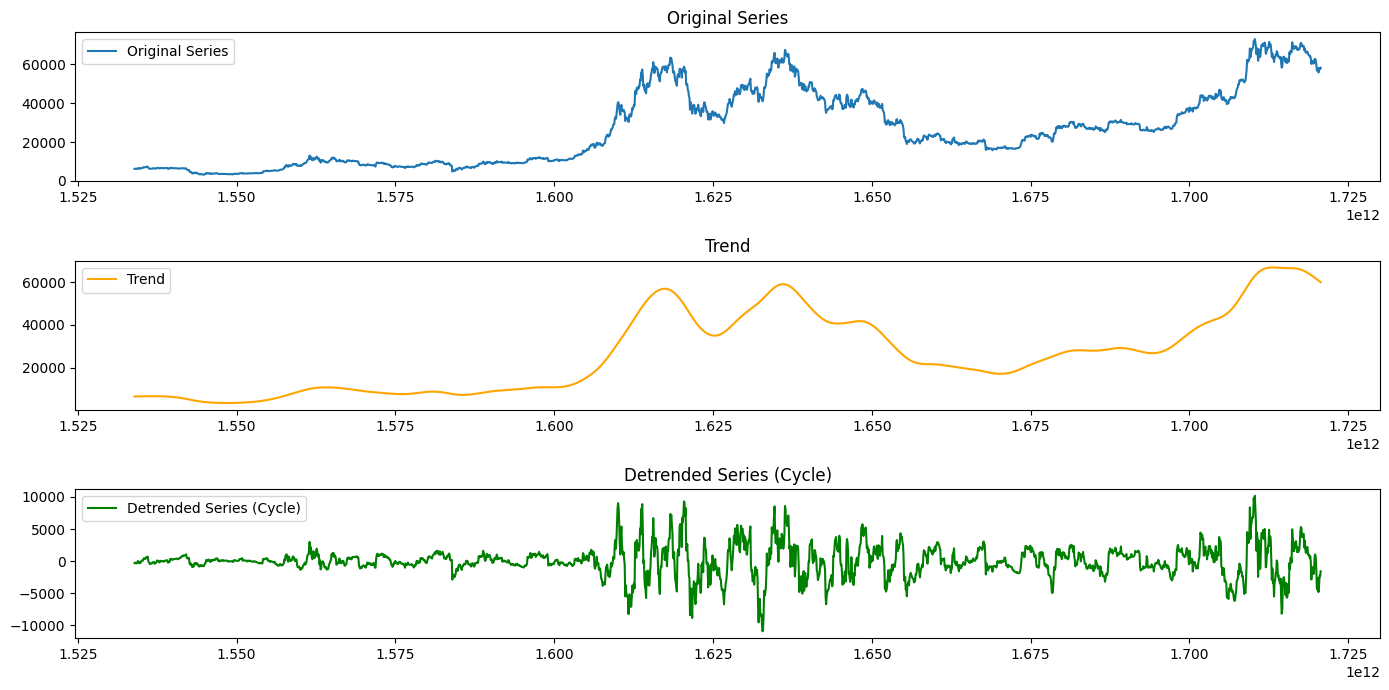

In [127]:
# Apply HP filter to the 'close' price series for a specific pair
pair_data = result.loc[(1)]
cycle, trend = hpfilter(pair_data['close'], lamb=129600)

# Store the cyclical component and the trend in the DataFrame
pair_data['price_detrended'] = cycle
pair_data['price_trend'] = trend

# Plot the original series, trend, and detrended series
plt.figure(figsize=(14, 7))

plt.subplot(3, 1, 1)
plt.plot(pair_data.index.get_level_values('open_time'), pair_data['close'], label='Original Series')
plt.title('Original Series')
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(pair_data.index.get_level_values('open_time'), pair_data['price_trend'], label='Trend', color='orange')
plt.title('Trend')
plt.legend()
plt.subplot(3, 1, 3)
plt.plot(pair_data.index.get_level_values('open_time'), pair_data['price_detrended'], label='Detrended Series (Cycle)', color='green')
plt.title('Detrended Series (Cycle)')
plt.legend()

plt.tight_layout()
plt.show()

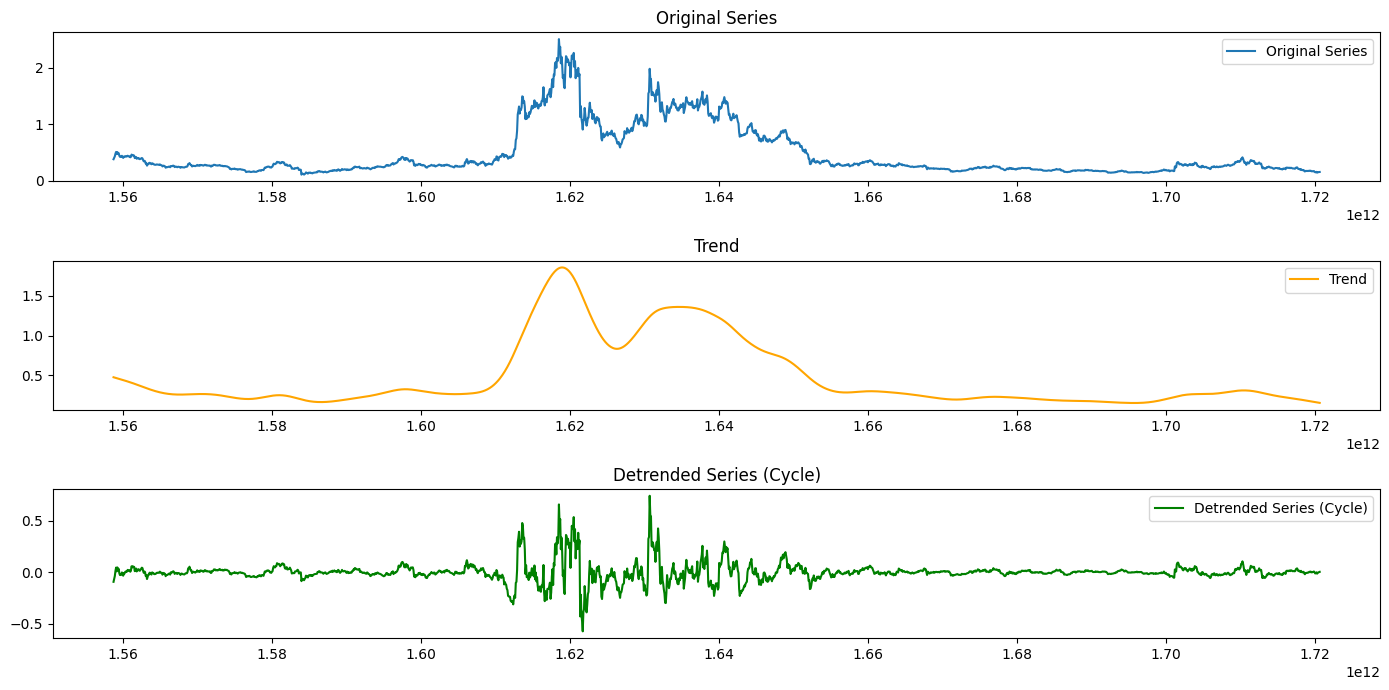

In [128]:

# Apply HP filter to the 'close' price series for a specific pair
pair_data = result.loc[(11)]
cycle, trend = hpfilter(pair_data['close'], lamb=129600)

# Store the cyclical component and the trend in the DataFrame
pair_data['price_detrended'] = cycle
pair_data['price_trend'] = trend

# Plot the original series, trend, and detrended series
plt.figure(figsize=(14, 7))

plt.subplot(3, 1, 1)
plt.plot(pair_data.index.get_level_values('open_time'), pair_data['close'], label='Original Series')
plt.title('Original Series')
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(pair_data.index.get_level_values('open_time'), pair_data['price_trend'], label='Trend', color='orange')
plt.title('Trend')
plt.legend()
plt.subplot(3, 1, 3)
plt.plot(pair_data.index.get_level_values('open_time'), pair_data['price_detrended'], label='Detrended Series (Cycle)', color='green')
plt.title('Detrended Series (Cycle)')
plt.legend()

plt.tight_layout()
plt.show()

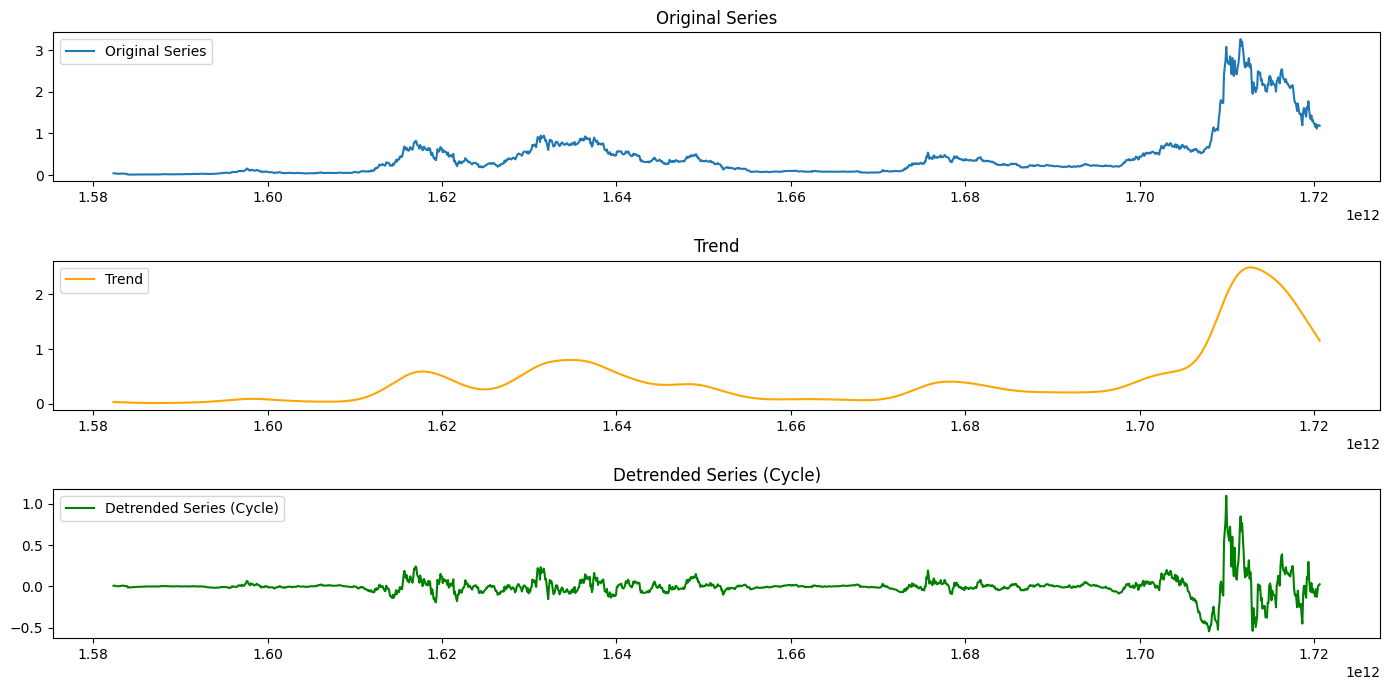

In [129]:

# Apply HP filter to the 'close' price series for a specific pair
pair_data = result.loc[(25)]
cycle, trend = hpfilter(pair_data['close'], lamb=129600)

# Store the cyclical component and the trend in the DataFrame
pair_data['price_detrended'] = cycle
pair_data['price_trend'] = trend

# Plot the original series, trend, and detrended series
plt.figure(figsize=(14, 7))

plt.subplot(3, 1, 1)
plt.plot(pair_data.index.get_level_values('open_time'), pair_data['close'], label='Original Series')
plt.title('Original Series')
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(pair_data.index.get_level_values('open_time'), pair_data['price_trend'], label='Trend', color='orange')
plt.title('Trend')
plt.legend()
plt.subplot(3, 1, 3)
plt.plot(pair_data.index.get_level_values('open_time'), pair_data['price_detrended'], label='Detrended Series (Cycle)', color='green')
plt.title('Detrended Series (Cycle)')
plt.legend()

plt.tight_layout()
plt.show()

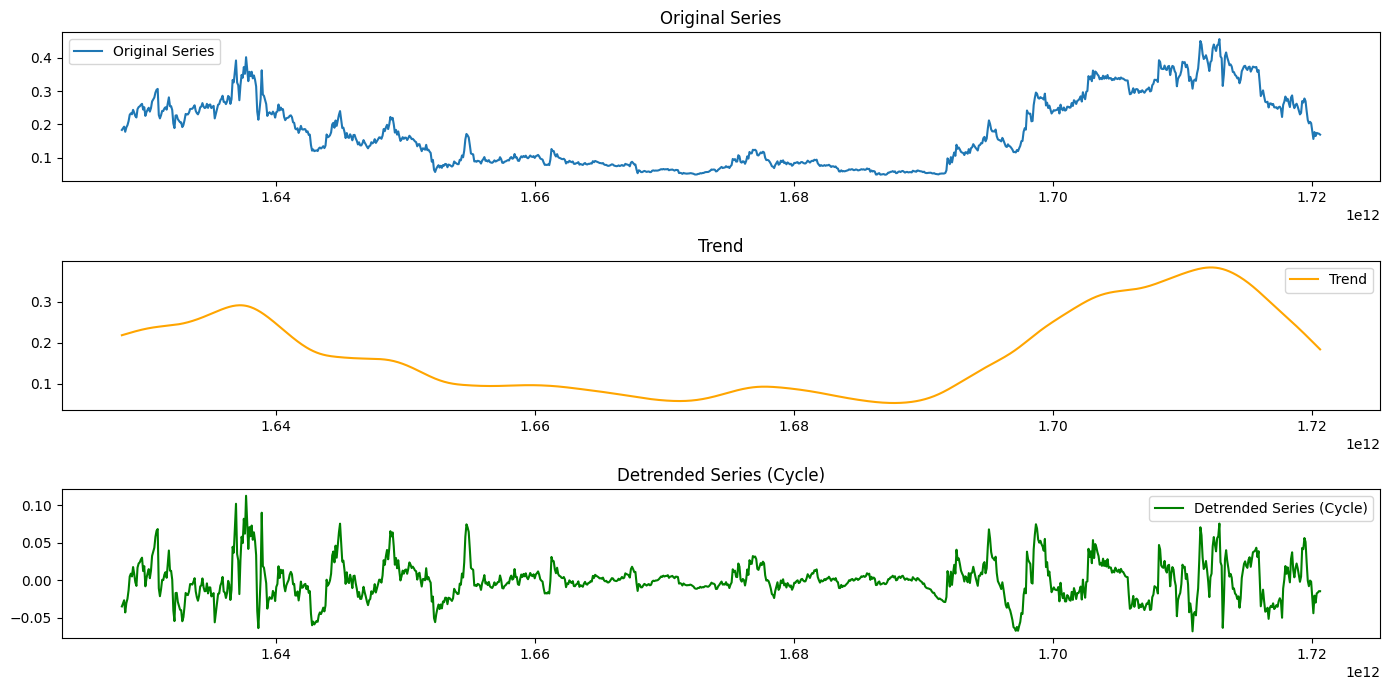

In [130]:

# Apply HP filter to the 'close' price series for a specific pair
pair_data = result.loc[(100)]
cycle, trend = hpfilter(pair_data['close'], lamb=129600)

# Store the cyclical component and the trend in the DataFrame
pair_data['price_detrended'] = cycle
pair_data['price_trend'] = trend

# Plot the original series, trend, and detrended series
plt.figure(figsize=(14, 7))

plt.subplot(3, 1, 1)
plt.plot(pair_data.index.get_level_values('open_time'), pair_data['close'], label='Original Series')
plt.title('Original Series')
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(pair_data.index.get_level_values('open_time'), pair_data['price_trend'], label='Trend', color='orange')
plt.title('Trend')
plt.legend()
plt.subplot(3, 1, 3)
plt.plot(pair_data.index.get_level_values('open_time'), pair_data['price_detrended'], label='Detrended Series (Cycle)', color='green')
plt.title('Detrended Series (Cycle)')
plt.legend()

plt.tight_layout()
plt.show()

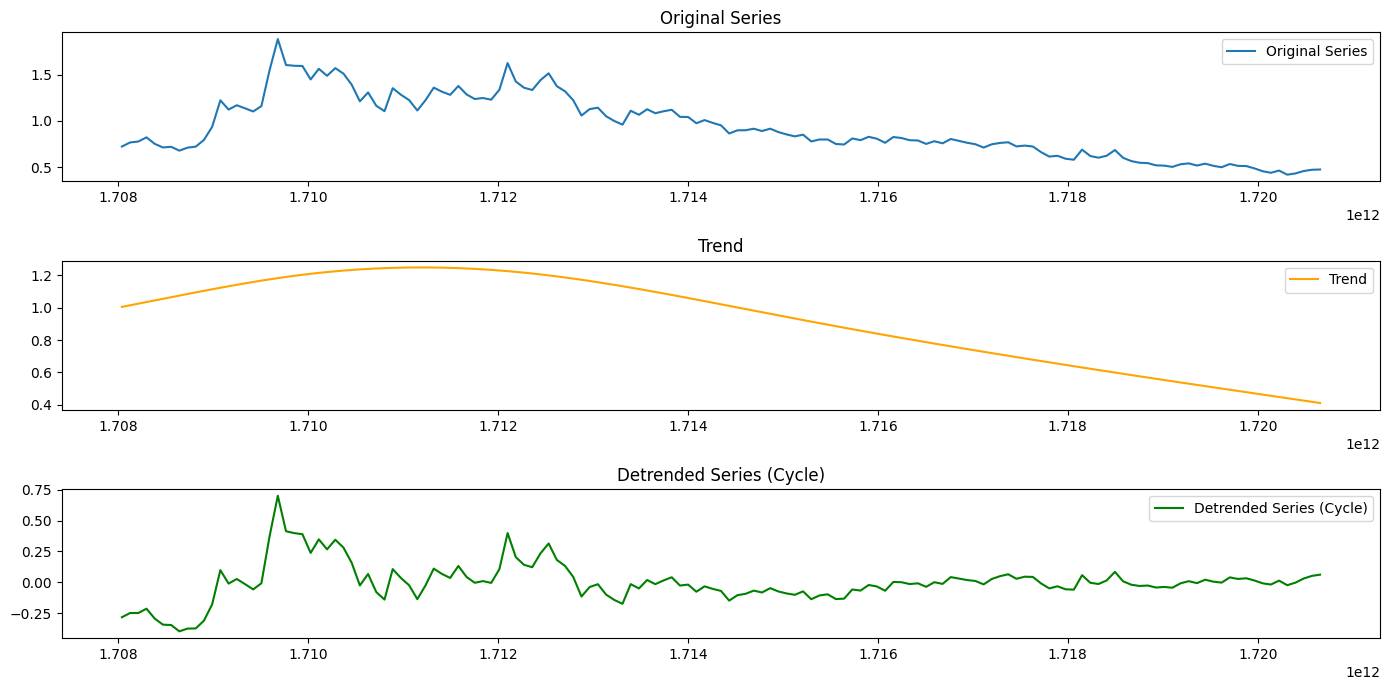

In [134]:

# Apply HP filter to the 'close' price series for a specific pair
pair_data = result.loc[(300)]
cycle, trend = hpfilter(pair_data['close'], lamb=129600)

# Store the cyclical component and the trend in the DataFrame
pair_data['price_detrended'] = cycle
pair_data['price_trend'] = trend

# Plot the original series, trend, and detrended series
plt.figure(figsize=(14, 7))

plt.subplot(3, 1, 1)
plt.plot(pair_data.index.get_level_values('open_time'), pair_data['close'], label='Original Series')
plt.title('Original Series')
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(pair_data.index.get_level_values('open_time'), pair_data['price_trend'], label='Trend', color='orange')
plt.title('Trend')
plt.legend()
plt.subplot(3, 1, 3)
plt.plot(pair_data.index.get_level_values('open_time'), pair_data['price_detrended'], label='Detrended Series (Cycle)', color='green')
plt.title('Detrended Series (Cycle)')
plt.legend()

plt.tight_layout()
plt.show()